This notebook searches for the ring positions in a series of images.

In [1]:
import time
start = time.time()
import os
import pylab as pl
import numpy as np
import numba
import scipy.ndimage as ndi
import hdf5plugin
import h5py
import fabio
from matplotlib.colors import LogNorm
from glob import glob
%matplotlib inline

First, load the data with the powder diffraction patterns

In [2]:


files = glob('lab6/*.cbf')
#files = files[:4]
print(files)

imgdct = {}
for file in files:
    imgdct[file] = fabio.open(file).data


['lab6\\lab6_000_-80_0001p.cbf', 'lab6\\lab6_000_00_0001p.cbf', 'lab6\\lab6_100_-80_0001p.cbf', 'lab6\\lab6_100_00_0001p.cbf', 'lab6\\lab6_200_-80_0001p.cbf', 'lab6\\lab6_200_00_0001p.cbf', 'lab6\\lab6_300_00_0001p.cbf']


In [3]:
cbf = fabio.open(files[0]).data #make this an array of an image from your detector

cbfhead = fabio.open(files[0]).header
cbfdata = cbfhead["_array_data.header_contents"].replace('\r','').split('\n')
for item in cbfdata:
    if 'Pixel_size' in item:
        pixx = round(float(item.split(' ')[2])*1000,3) #x 1000 to convert to mm
        pixy = round(float(item.split(' ')[5])*1000,3)
        break
        
        
y,x = np.where(cbf == -1) #change this condition if gaps are defined differently
cbfysize = len(cbf)
cbfxsize = len(cbf[0])
print(f'detector size = {cbfxsize}x{cbfysize}')


xgaps = []
ygaps = []
for i in set(x):
    if len(np.where(x==i)[0]) == cbfysize:
        xgaps.append(i)
for i in set(y):
    if len(np.where(y==i)[0]) == cbfxsize:
        ygaps.append(i)

xgapedge = []
ygapedge = []

lengapx = 0
lengapy = 0

foffset = [0]
soffset = [0]
gapno = 0
for i in range(len(xgaps[1:])+1):
    lengapx += 1
    if xgaps[i] != xgaps[i-1] + 1:
        xgapedge.append(xgaps[i])
        
        gapno += 1
        foffset.append(lengapx)

    elif xgaps[i] == xgaps[i-1]+1: 
        foffset[gapno] += 1

gapno = 0
for i in range(len(ygaps[1:])+1):
    lengapy += 1
    if ygaps[i] != ygaps[i-1] + 1:
        ygapedge.append(ygaps[i])
        gapno += 1
        soffset.append(lengapy)
    elif ygaps[i] == ygaps[i-1]+1:
        soffset[gapno] += 1
print(f'gap edges fast axis = {xgapedge}, slow axis = {ygapedge}')

noxmodules = len(xgapedge) + 1
noymodules = len(ygapedge) + 1
no_modules = noxmodules*noymodules
print(f'number of modules = {noxmodules}x{noymodules} = {no_modules}')

fsize = xgaps[0]
ssize = ygaps[0]
print(f'fast size = {fsize}, slow size = {ssize}')

foffset = np.array(foffset)
soffset = np.array(soffset)
ygapsizes = [soffset[i]-soffset[i-1] for i in range(1,len(soffset))]
xgapsizes = [foffset[i]-foffset[i-1] for i in range(1,len(foffset))]


print(f'slow offsets = {soffset}, fast offsets = {foffset}')

detector size = 1475x1679
gap edges fast axis = [487, 981], slow axis = [195, 407, 619, 831, 1043, 1255, 1467]
number of modules = 3x8 = 24
fast size = 487, slow size = 195
slow offsets = [  0  17  34  51  68  85 102 119], fast offsets = [ 0  7 14]


lab6\lab6_000_-80_0001p.cbf


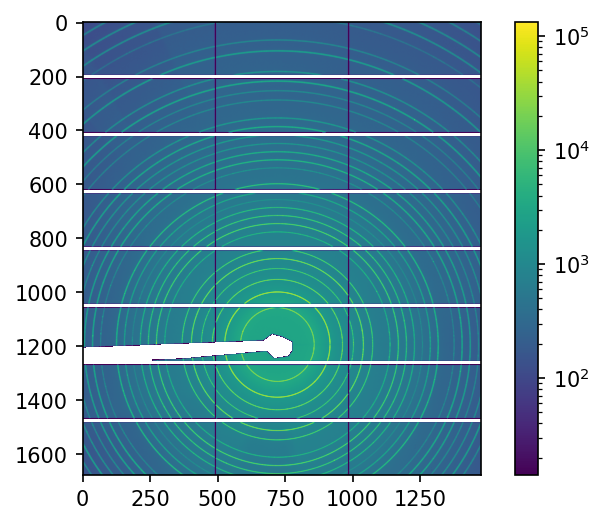

In [4]:
# load and display a demo image
print(files[0])
img = imgdct[files[0]]
maskfile = 'pyfai_300_00_mask.edf'
maskfile80 = 'pyfai_200_-80_mask.edf'
mask = fabio.open(maskfile).data
mask80 = fabio.open(maskfile80).data
msk = mask == 0
msk80 = mask80 == 0
#mask = img > 0
pl.figure(dpi = 150)

pl.imshow( img * msk80, norm = LogNorm() )
pl.colorbar()

<IPython.core.display.Javascript object>


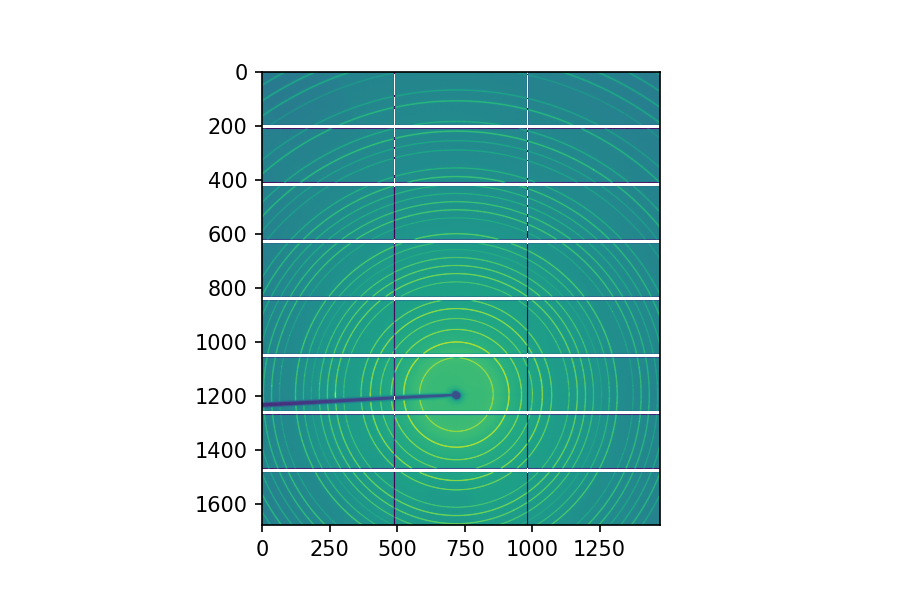

<IPython.core.display.Javascript object>


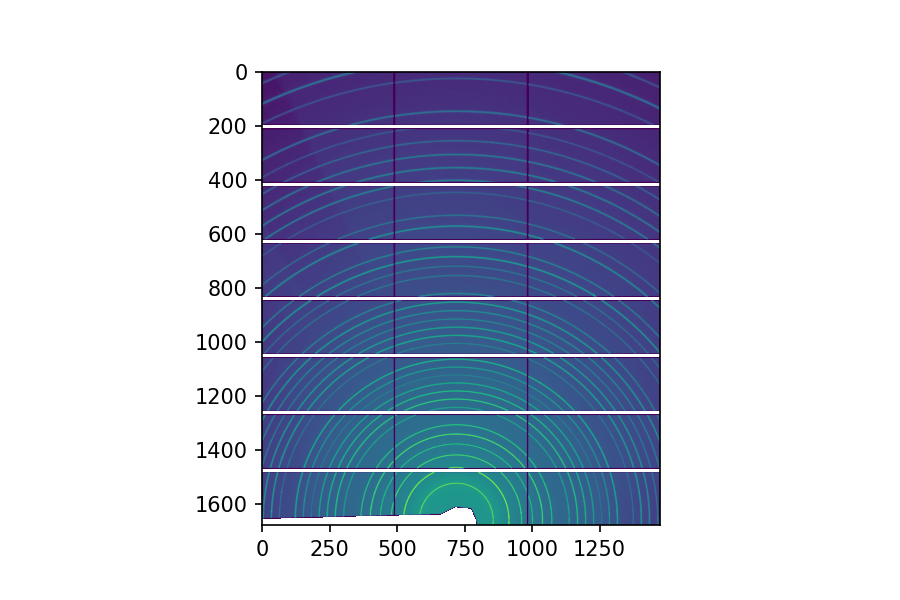

In [5]:
#h = h5py.File(h5name,'r')
%matplotlib nbagg
pl.figure(dpi = 150)
pl.imshow(imgdct[files[0]],norm = LogNorm())
pl.figure(dpi = 150)
pl.imshow(imgdct[files[1]]*msk,norm = LogNorm())

Geometric description of the Eiger4M modules:

In [6]:
# Geometry of the modules
# fast = 0 - 486
# slow = 0 - 194
# 3x8 grid of these

def mod_start(s,f):
    """ s, f are the module coordinates in the range 0-4
    s/f refer to fast/slow pixel directions to use in C style
    array indexing data[s][f].
    returns the first pixel in the corner of the module
    """
    global fsize
    global foffset
    global ssize
    global soffset

    fstart = fsize*f + foffset[f]
    sstart = ssize*s + soffset[s]
    return sstart, fstart

def module(image, s, f):
    """ image is a full Pilatus2m image.
    s,f selects one of the modules 
    pad (for debugging) adds a border around the module
    """
    global fsize
    global foffset
    global ssize
    global soffset
    
    #p = padding around the outside for debug

    fstart = fsize*f + foffset[f]
    sstart = ssize*s + soffset[s]
    roi = image[ sstart : sstart + ssize,
                 fstart : fstart + fsize]
    return roi

C:\Users\kenneth1a\AppData\Local\Temp\ipykernel_18748\190559093.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


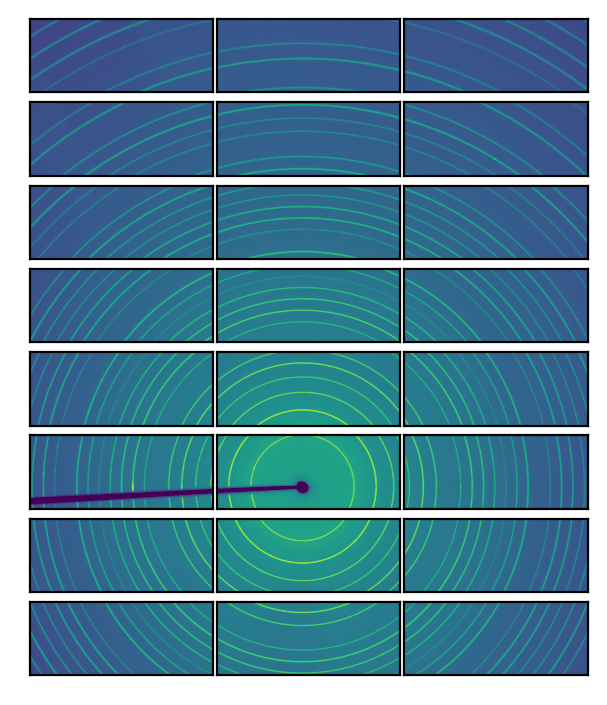

In [7]:
# check we have the module geometry
%matplotlib inline
fig, ax = pl.subplots(len(soffset),len(foffset),dpi = 200,gridspec_kw = {'wspace':0.02,'hspace':0.02},
                      figsize = (len(foffset)*1.2,len(soffset)*0.55))
for s in range(len(soffset)):
    for f in range(len(foffset)):
        ax[s][f].imshow( module(img,s,f), norm=pl.matplotlib.colors.LogNorm(20,max(img.flatten())))
        ax[s][f].set(xticks=[], yticks=[])
fig.tight_layout()

C:\Users\kenneth1a\AppData\Local\Temp\ipykernel_18748\2316934279.py:4: RuntimeWarning: invalid value encountered in sqrt
  sigdata = np.sqrt(img) # approximation


(0.0, 5000.0)

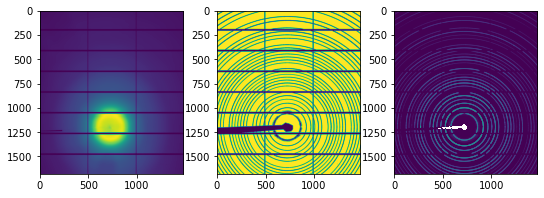

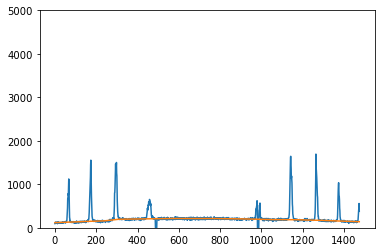

In [8]:
# Estimate what is peak and background
def guessbg( img, nsigma = 5, size = 64, cycles = 5, saturated=pow(2,31),mask=mask80):
    msk = ( img < saturated ) & ( img > 0 ) & (mask == 0)
    sigdata = np.sqrt(img) # approximation
    for i in range(3):
        cimg  = img.astype(np.float32) * msk
        sumpx = ndi.uniform_filter( cimg, size=size, mode='constant', cval=0 )
        sum1  = ndi.uniform_filter( msk.astype(np.float32),  size=size, mode='constant' )
        avg   = sumpx / np.where(sum1>0, sum1, 1)
        pks   = cimg > avg + sigdata * nsigma
        msk   = msk & (~pks)
    cimg = img.astype(np.float32) * msk
    sumpx = ndi.uniform_filter( cimg, size=size, mode='constant' )
    sum1  = ndi.uniform_filter( msk.astype(np.float32), size=size, mode='constant' )
    avg   = sumpx / np.where(sum1>0, sum1, 1)
    return avg, msk

bkgimage, bgmask = guessbg( img )
msk = img > 0
bim = (img.astype(np.float32) - bkgimage)*msk

fig, ax = pl.subplots(1, 3, figsize=(9,3))
ax[0].imshow( bkgimage * msk )
ax[1].imshow( bgmask )
ax[2].imshow( bim + 1000, norm=LogNorm(vmin=1000) )
pl.figure()
pl.plot((img*msk)[10])
pl.plot(bkgimage[10])
pl.ylim(0,5000)

In [9]:
help(ndi.uniform_filter)

Help on function uniform_filter in module scipy.ndimage.filters:

uniform_filter(input, size=3, output=None, mode='reflect', cval=0.0, origin=0)
    Multidimensional uniform filter.
    
    Parameters
    ----------
    input : array_like
        The input array.
    size : int or sequence of ints, optional
        The sizes of the uniform filter are given for each axis as a
        sequence, or as a single number, in which case the size is
        equal for all axes.
    output : array or dtype, optional
        The array in which to place the output, or the dtype of the
        returned array. By default an array of the same dtype as input
        will be created.
    mode : str or sequence, optional
        The `mode` parameter determines how the input array is extended
        when the filter overlaps a border. By passing a sequence of modes
        with length equal to the number of dimensions of the input array,
        different modes can be specified along each axis. Default v

We will go through the modules one by one and look for peaks in each row and column of pixels. 

In [10]:
@numba.njit
def fitpks(signal, msk, mbg, bgv, minpk=4, maxpk=36, label = 0):
    """ 
    signal is a 2D array with peaks in it
    msk defines which pixels can be used (skip values > 1e9)
    mbg labels pixels as being part of peak or background
    bgv estimate of the background level
    minpk = 4  : number of pixels needed to define a peak
    maxpk = 35 : max number of pixels allowed in a peak
    label = int : to track where peaks came from
    
    condition is finding bg->pk->bg with (maxpk > s1 > minpk) 
    
    The +1 is due to the clipping before calling this function (???)
    
    returns a list of peaks, each peak is:
      (slow_center, fast_center, sum_signal, npixels, fixed_index, module_label)
    """
    pks=[]
    for i in range(signal.shape[0]):
        s1 = 0       # sum of pixels in peak
        sI = 0       # sum of intensity in peak
        sfI = 0      # sum of intensity * fast pixel co-ordindate
        gotbg = False
        for j in range(signal.shape[1]):
            if msk[i,j] == 1: # pixels can be used
                if mbg[i,j] == 1: # in background
                    gotbg = True
                    # save the last peak if there was one
                    if s1 > minpk and s1 < maxpk:
                        # centre of mass position is sfI/sI
                        pks.append( (i , float(sfI) / sI , sI, s1, 0, label ) )
                    # ... and reset peak counters
                    s1 = 0; sI = 0; sfI = 0
                else: # inside a peak
                    if gotbg:
                        s1  += 1; 
                        sI  += (signal[i,j]-bgv)
                        sfI += (signal[i,j]-bgv)*j
            else: # just saw mask, so reset sums
                s1  = 0
                sfI = 0
                sI  = 0
                gotbg = False
    # Now repeat the same code but for the transposed array
    for j in range(signal.shape[1]):
        s1 = 0
        sI = 0
        ssI = 0
        gotbg = False
        for i in range(signal.shape[0]):
            if msk[i,j] == 1: # pixels can be used
                if mbg[i,j] == 1: # in background
                    gotbg = True
                    if s1 >= minpk and s1 < maxpk:
                        pks.append( ( float(ssI) / sI , j , sI, s1, 1, label))
                    s1 = 0; sI = 0; ssI = 0
                else: # in peak
                    if gotbg:
                        s1  += 1
                        sI  += (signal[i,j]-bgv) 
                        ssI += (signal[i,j]-bgv)*i
            else:
                s1 = 0
                ssI = 0
                sI = 0
    if len(pks) == 0:
        return None
    else:
        return np.array(pks)

def process_chip(chip, plt=0, modu=0, nsigma=3):
    """ chip = 2D array
    
    plt > 0 : plot spot positions
    plt < 0 : show segmentation and peak positions
    
    modu = module label
    
    Defines a mask
    Thresholds to determine what is peak versus background
    Runs fitpks to get peak positions
    return peak positions
    """
    roi = chip.copy()
    msk = roi > 0    # Dectris mask
    roi = roi * msk    # zeros out the bad pixels
    sel = msk          # select all pixels as background
    for i in range(5):
        m = roi[sel].mean()   # mean background value
        s = roi[sel].std()    # sigma - clipping method (from pyFAI / vamvakeros / et al)
        sel = (roi < m+s*nsigma) & msk
    bg1 = roi[sel].mean()    
    mbg = sel
    pks = fitpks( roi, msk, mbg, bg1, minpk=3, label=modu )
    return pks, mbg

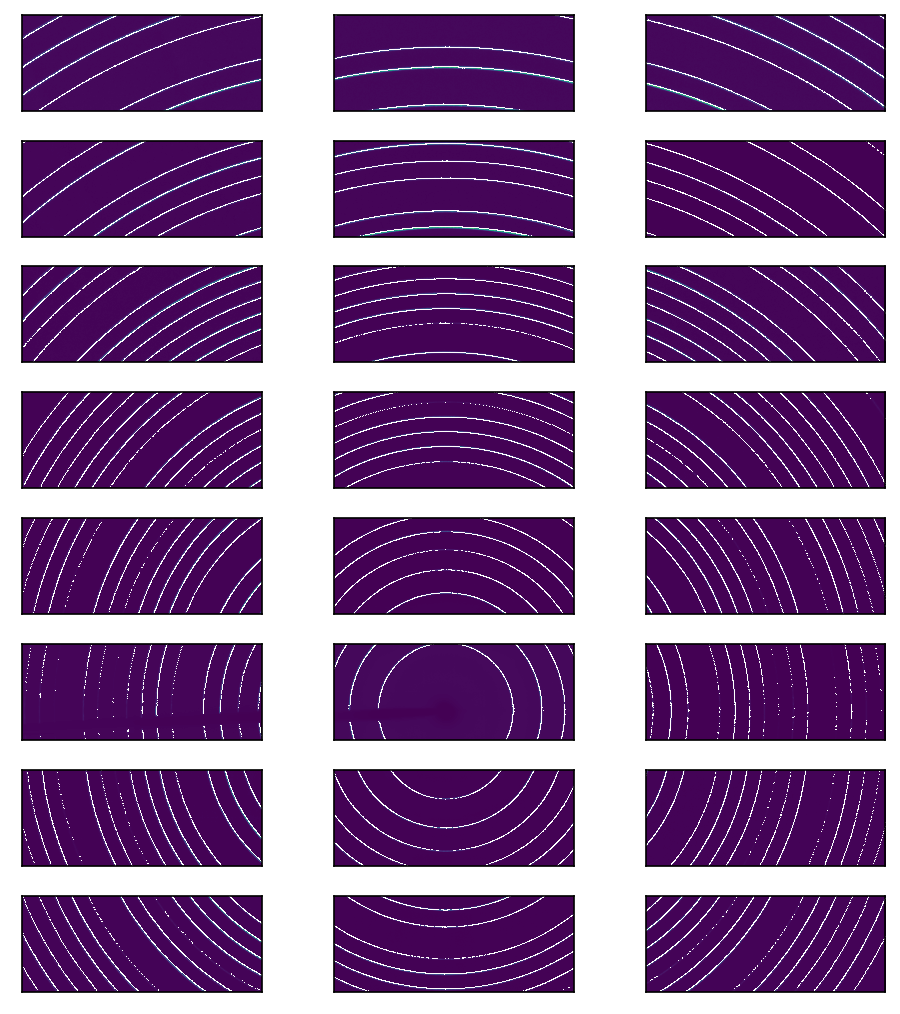

In [11]:
# test with plot
fig, ax = pl.subplots(len(soffset), len(foffset), 
                      figsize=(3*len(foffset)*fsize/(fsize+ssize),3*len(soffset)*ssize/(fsize+ssize)),
                      dpi = 150)
for i in range(len(soffset)):
    for j in range(len(foffset)):
        roi = module(bim,i,j)
        pks, mbg = process_chip(roi, plt=i*len(foffset)+j+1, modu=i*len(foffset)+i)
        ax[i][j].imshow( roi )
        ax[i][j].plot( pks[:,1], pks[:,0], "w," )
        ax[i][j].set(xticks=[], yticks=[])
fig.tight_layout()

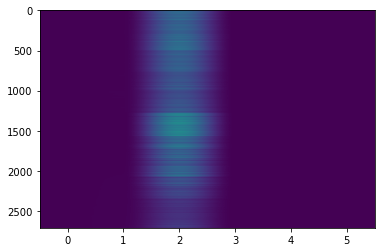

In [12]:
pl.figure()
pl.imshow(pks,aspect = 'auto')

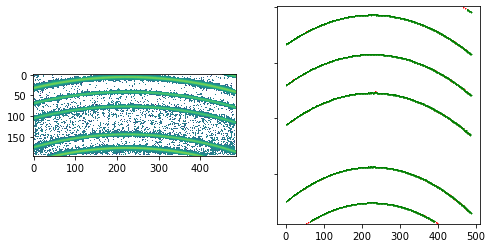

In [13]:
fig, ax = pl.subplots(1,2, sharey=True, figsize=(8,4))
roi = module(bim,1,1)
ax[0].imshow(roi, norm=LogNorm(vmax=200000),aspect='equal')
pks, mbg = process_chip(module(bim,1,1), plt=-1)
s=pks[:,4]==0
ax[1].plot( pks[s,1],pks[s,0], "r+", ms=1)
ax[1].plot( pks[~s,1],pks[~s,0], "g+", ms=1)

In [14]:
def search_image(im,mask):
    """Loops over the modules"""
    allpks = []
    bkgimage, bgmask = guessbg( im ,mask = mask)
    msk = im > 0
    bim = (im.astype(np.float32) - bkgimage)*msk
    for i in range(len(soffset)):
        for j in range(len(foffset)):
            cs = module(bim,i,j)
            pks, mbg = process_chip(cs, modu=i*len(foffset)+j)
            io, jo = mod_start(i,j)
            if pks is not None:
                pks[:,0] += io
                pks[:,1] += jo
                allpks.append(pks)
    ap = np.concatenate(allpks,axis=0).T
    return ap

In [15]:
%%time
p = search_image(img,mask = mask80)
print(p.shape)

C:\Users\kenneth1a\AppData\Local\Temp\ipykernel_18748\2316934279.py:4: RuntimeWarning: invalid value encountered in sqrt
  sigdata = np.sqrt(img) # approximation


(6, 57367)
CPU times: total: 1.22 s
Wall time: 1.21 s


C:\Users\kenneth1a\AppData\Local\Temp\ipykernel_18748\2316934279.py:4: RuntimeWarning: invalid value encountered in sqrt
  sigdata = np.sqrt(img) # approximation


(6, 57367)


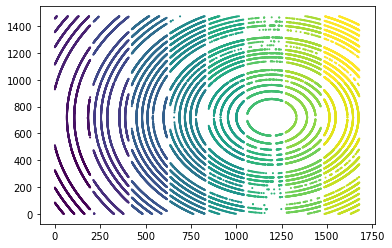

In [16]:
sc,fc,sI,s1,sf,m = p = search_image(img,mask = mask80)
pl.figure()
pl.scatter(sc,fc,c=m,s=1)
print(p.shape)

In [17]:
def saveflt(outname, pks):
    """Save the peaks into ImageD11 columnfile format (text file)"""
    with open(outname,"w") as f:
        f.write("#  sc  fc  omega  Number_of_pixels  sum_intensity  direction  module  s_raw  f_raw\n")
        for sc,fc,I,s1,sf,m in pks.T:
            f.write("%.3f %.3f 0.0 %d %.1f %d %d %.3f %.3f\n"%(sc,fc,s1,I,sf,m,sc,fc))
saveflt("demo.flt", p) 

In [18]:
!cd #for windows. Use pwd for unix
outputdir = 'pilatusSpatial'
if not os.path.exists(outputdir):
    os.mkdir(outputdir)

The system cannot find the path specified.


In [22]:
# Now search all the images and save the output

for file in imgdct:
    if '-80' in file:
        currentmask = mask80
    elif '_00_' in file:
        currentmask = mask
    frms = imgdct[file]
    #print(imgdct[file],frms.shape,np.median(frms[1,:256,:256]))
    im = frms[:].sum(axis=0)
    pks = search_image( frms , mask = currentmask)
    outname = f"{outputdir}/{os.path.splitext(os.path.basename(file))[0]}.flt"
    saveflt(outname, pks) 

C:\Users\kenneth1a\AppData\Local\Temp\ipykernel_18748\2316934279.py:4: RuntimeWarning: invalid value encountered in sqrt
  sigdata = np.sqrt(img) # approximation


<IPython.core.display.Javascript object>


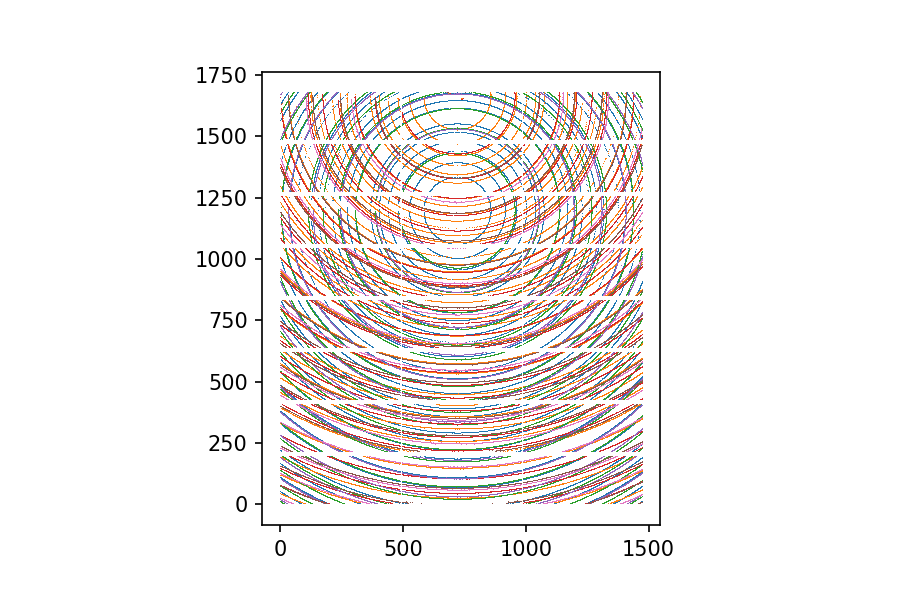

In [24]:
from ImageD11.columnfile import columnfile
%matplotlib nbagg
pl.figure(dpi = 150)
for fname in sorted(glob(f"{outputdir}/*.flt")):
    c = columnfile( fname)
    pl.plot(c.fc,c.sc,',')
pl.gca().set_aspect('equal')

In [25]:
print("Output created on %s"%(time.ctime()))
print("Total runtime %.3f /s"%(time.time()-start))

Output created on Wed Aug 10 16:56:41 2022
Total runtime 208.509 /s
